In [27]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [28]:
data_path = "../data/raw/training_data_trees.npz"
npz = np.load(data_path)
X = npz["X"]
y = npz["y"]
X.shape, y.shape

((500000, 20), (500000,))

In [29]:
# Feature names
feature_names = [f"p{i}" for i in range(10)] + [
    "p_min","p_max","p_mean","p_std","realized_vol","K","T","r","sigma","option_flag"
]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [31]:
X_train, X_test, y_train, y_test

(array([[1.00000000e+02, 9.75556061e+01, 8.92618415e+01, ...,
         3.06396435e-02, 4.25828141e-01, 0.00000000e+00],
        [1.00000000e+02, 9.35101273e+01, 9.20306252e+01, ...,
         1.87270059e-02, 4.77821438e-01, 2.00000000e+00],
        [1.00000000e+02, 9.61112420e+01, 9.61418565e+01, ...,
         2.14287269e-02, 2.76256083e-01, 2.00000000e+00],
        ...,
        [1.00000000e+02, 1.07225929e+02, 1.06464991e+02, ...,
         3.72537836e-02, 4.14652280e-01, 3.00000000e+00],
        [1.00000000e+02, 1.02730281e+02, 1.03670588e+02, ...,
         2.18479822e-02, 1.66703136e-01, 1.00000000e+00],
        [1.00000000e+02, 1.01568769e+02, 1.00930279e+02, ...,
         1.37586219e-02, 3.34377514e-01, 3.00000000e+00]],
       shape=(400000, 20)),
 array([[1.00000000e+02, 9.90088711e+01, 9.93241645e+01, ...,
         4.86273499e-02, 3.10701284e-01, 2.00000000e+00],
        [1.00000000e+02, 9.51697388e+01, 8.91252245e+01, ...,
         4.17732274e-02, 4.60215130e-01, 2.00000000e+00]

In [32]:
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # manual RMSE for older sklearn
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f" RMSE = {rmse:.4f}")
    print(f" MAE  = {mae:.4f}")
    print(f" R^2  = {r2:.4f}")
    return {"rmse": rmse, "mae": mae, "r2": r2}

In [33]:
def show_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    else:
        print(f"{model_name} has no feature_importances_ attribute.")
        return
    
    # Normalize to percentage
    importance = 100.0 * importance / importance.sum()
    
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values(by="importance", ascending=False)
    
    # Print top N in text
    print(f"\nTop {top_n} features for {model_name}:")
    print(fi_df.head(top_n).to_string(index=False))
    
    # Save full importance to CSV
    csv_file = f"{model_name}_feature_importance.csv"
    fi_df.to_csv(csv_file, index=False)
    print(f"Saved full feature importance to {csv_file}")
    
    # Plot top N
    fi_df.head(top_n).plot(kind="barh", x="feature", y="importance",
                           legend=False, figsize=(8,6))
    plt.title(f"Top {top_n} Feature Importances ({model_name})")
    plt.gca().invert_yaxis()
    plt.show()

c:\Users\aisha\OneDrive\Desktop\GitHub\neural-pricer\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



LightGBM Performance:
 RMSE = 15.0870
 MAE  = 7.8321
 R^2  = 0.5041

Top 20 features for LightGBM:
     feature  importance
          p9    9.152381
realized_vol    7.301587
          p1    7.219048
          p2    6.714286
          p8    6.101587
          p3    6.082540
          p4    5.819048
          p5    5.796825
          p6    5.641270
          p7    5.250794
           K    5.028571
       p_std    4.688889
           T    4.114286
       p_max    4.034921
       p_min    3.917460
      p_mean    3.742857
 option_flag    3.295238
       sigma    3.196825
           r    2.901587
          p0    0.000000
Saved full feature importance to LightGBM_feature_importance.csv


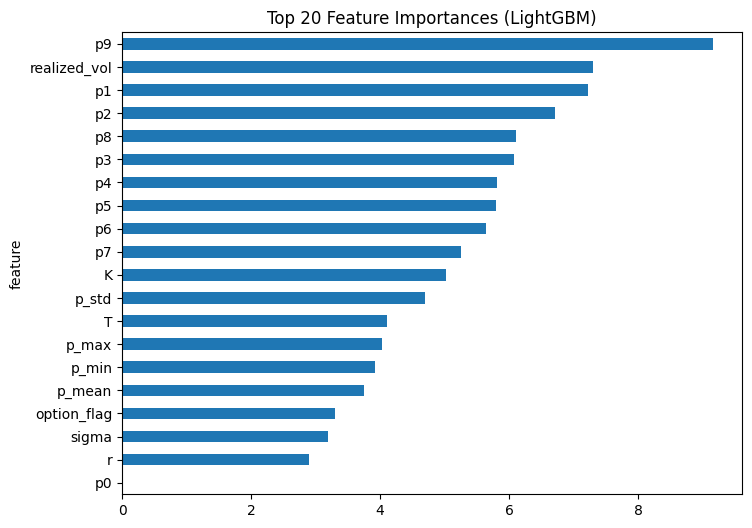

In [38]:
lgb_model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=64,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1   # silence output
    )
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)

y_pred_lgb = lgb_model.predict(X_test)
results_lgb = evaluate_model("LightGBM", y_test, y_pred_lgb)

show_feature_importance(lgb_model, feature_names, top_n=20, model_name="LightGBM")


XGBoost Performance:
 RMSE = 15.1538
 MAE  = 7.8644
 R^2  = 0.4997

Top 20 features for XGBoost:
     feature  importance
           K   27.328285
           T   13.342104
           r   12.596338
 option_flag   12.242904
       sigma    8.143054
          p9    6.595566
          p8    3.349128
       p_max    2.901990
       p_min    2.181601
realized_vol    1.448044
       p_std    1.278458
      p_mean    1.200041
          p5    1.130967
          p7    1.110843
          p6    1.088101
          p4    1.075202
          p3    1.068591
          p2    1.004933
          p1    0.913853
          p0    0.000000
Saved full feature importance to XGBoost_feature_importance.csv


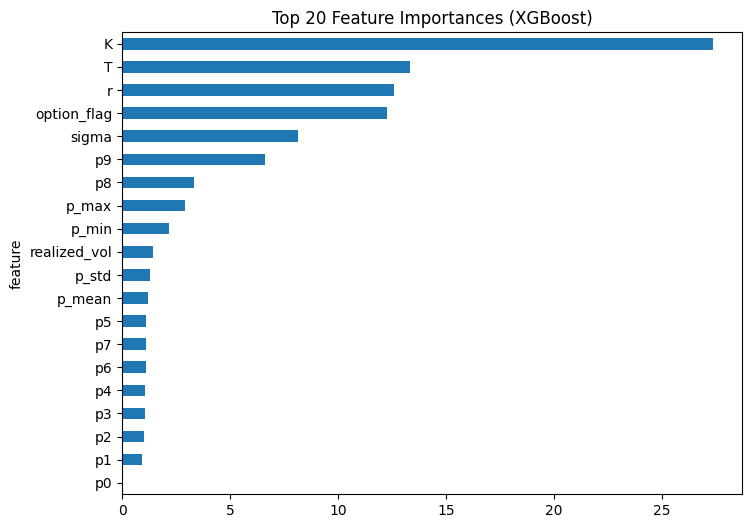

In [39]:
xgb_model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        eval_metric="rmse"   # moved here for old versions
    )
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # suppress too much logging
)

y_pred_xgb = xgb_model.predict(X_test)
results_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb)

show_feature_importance(xgb_model, feature_names, top_n=20, model_name="XGBoost")

In [40]:
if results_lgb: print("LightGBM:", results_lgb)
if results_xgb: print("XGBoost:", results_xgb)

LightGBM: {'rmse': np.float64(15.087043833153457), 'mae': 7.832149599892993, 'r2': 0.5041459616209724}
XGBoost: {'rmse': np.float64(15.15384233109902), 'mae': 7.8643763117864935, 'r2': 0.4997454136402292}


- Models explain only about 50% of the variance in the payoff data.
- LightGBM: focuses much more on the prefix path features and realized_vol, and contract params are secondary.
- XGBoost: relies heavily on contract parameters (K, T, r, sigma, option_flag). Prefix prices are less influential except p8/p9.
- Both models learning different heuristics about what matters.

- Dataset is noisy?
- Simulating random GBM paths with 2000 paths per parameter combo. Payoffs, especially for digitals and OTM options, have huge variance.
- Digitals, asians, and vanillas have very different payoff structures - mixing them confuses the models
- Variance of payoffs grows with strike/sigma/T, making regression harder. Trees are sensitive to this.

## TRIAL 2

In [42]:
data_file = "../data/raw/training_data_trees.npz"
data = np.load(data_file)
X, y = data["X"], data["y"]

In [43]:
feature_names = [f"p{i}" for i in range(10)] + [
    "p_min","p_max","p_mean","p_std","realized_vol","K","T","r","sigma","option_flag"
]

# Map option_flag to readable labels
option_map = {0.0:"put", 1.0:"call", 2.0:"digital", 3.0:"asian"}
option_flags = np.unique(X[:, -1])

In [46]:
def show_feature_importance(model, feature_names, top_n=15, model_name="Model", suffix=""):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    else:
        print(f"{model_name} has no feature_importances_ attribute.")
        return
    
    importance = 100.0 * importance / importance.sum()
    
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values(by="importance", ascending=False)
    
    print(f"\nTop {top_n} features for {model_name} ({suffix}):")
    print(fi_df.head(top_n).to_string(index=False))
    
    csv_file = f"{model_name}_feature_importance_{suffix}.csv"
    fi_df.to_csv(csv_file, index=False)
    print(f"Saved full feature importance to {csv_file}")
    
    fi_df.head(top_n).plot(kind="barh", x="feature", y="importance",
                           legend=False, figsize=(8,6))
    plt.title(f"Top {top_n} Feature Importances ({model_name}, {suffix})")
    plt.gca().invert_yaxis()
    plt.show()


Training models for option type: put

--- LightGBM ---


c:\Users\aisha\OneDrive\Desktop\GitHub\neural-pricer\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



LightGBM Performance:
 RMSE = 16.8414
 MAE  = 11.3015
 R^2  = 0.5059

Top 15 features for LightGBM (put):
     feature  importance
          p9    7.847619
realized_vol    7.746032
          p2    7.450794
          p1    7.304762
          p3    6.825397
          p4    6.815873
          p7    6.685714
          p8    6.653968
          p5    6.647619
          p6    6.600000
       p_std    5.847619
       p_min    4.796825
       p_max    4.726984
      p_mean    4.676190
           K    4.161905
Saved full feature importance to LightGBM_feature_importance_put.csv


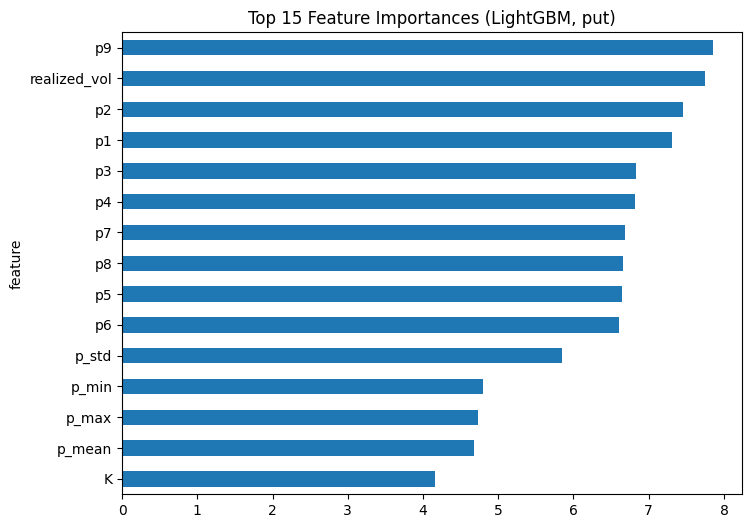


--- XGBoost ---

XGBoost Performance:
 RMSE = 16.8942
 MAE  = 11.3140
 R^2  = 0.5028

Top 15 features for XGBoost (put):
     feature  importance
           K   26.104172
       sigma   25.144978
           r   19.953876
           T    7.161506
          p9    6.703569
       p_min    1.872172
       p_max    1.286964
      p_mean    1.239740
          p8    1.224393
       p_std    1.215699
realized_vol    1.170099
          p7    1.157593
          p6    1.129807
          p5    1.054828
          p4    1.028360
Saved full feature importance to XGBoost_feature_importance_put.csv


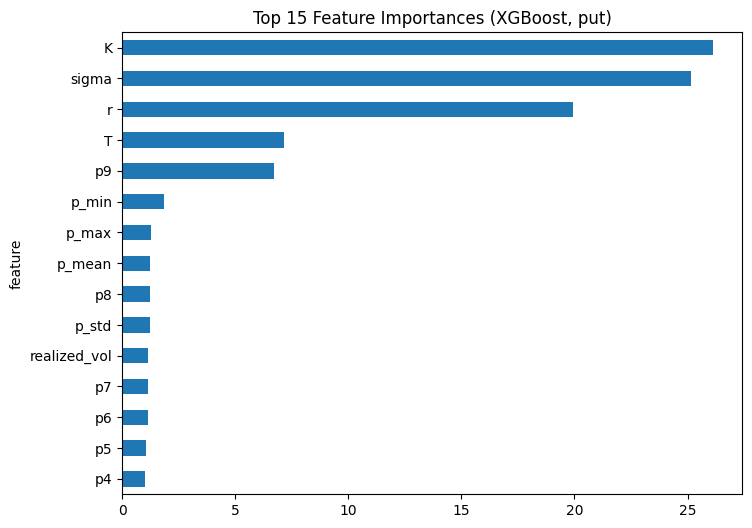


Training models for option type: call

--- LightGBM ---

LightGBM Performance:
 RMSE = 22.1497
 MAE  = 11.8675
 R^2  = 0.2948

Top 15 features for LightGBM (call):
     feature  importance
realized_vol    8.409524
          p2    8.276190
          p1    8.149206
          p9    7.984127
          p3    7.733333
          p4    7.384127
          p5    6.946032
          p8    6.828571
          p7    6.669841
          p6    6.526984
       p_std    6.031746
      p_mean    4.815873
       p_max    4.660317
       p_min    4.212698
           K    2.003175
Saved full feature importance to LightGBM_feature_importance_call.csv


c:\Users\aisha\OneDrive\Desktop\GitHub\neural-pricer\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


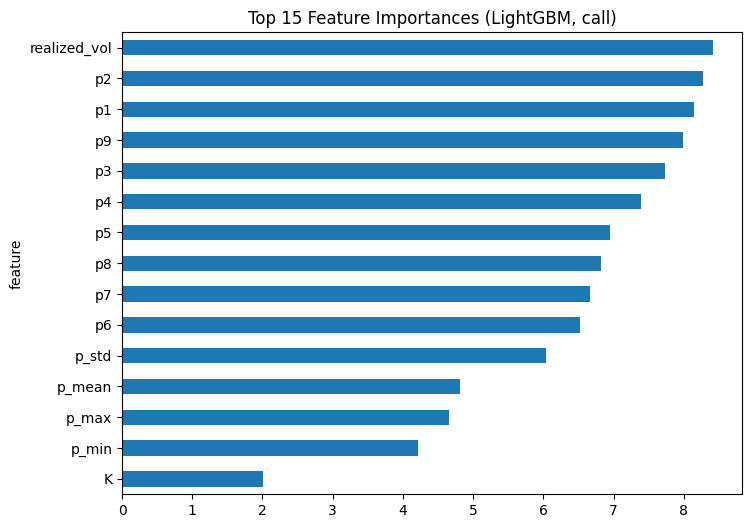


--- XGBoost ---

XGBoost Performance:
 RMSE = 22.2516
 MAE  = 11.9529
 R^2  = 0.2883

Top 15 features for XGBoost (call):
     feature  importance
           T   24.838291
           K   24.173246
       sigma    9.333082
          p9    8.264864
           r    3.655426
realized_vol    3.326845
       p_max    3.069405
       p_min    2.461104
       p_std    2.392495
          p8    2.280105
          p6    2.215909
      p_mean    2.103557
          p7    2.096534
          p4    2.095590
          p3    2.090997
Saved full feature importance to XGBoost_feature_importance_call.csv


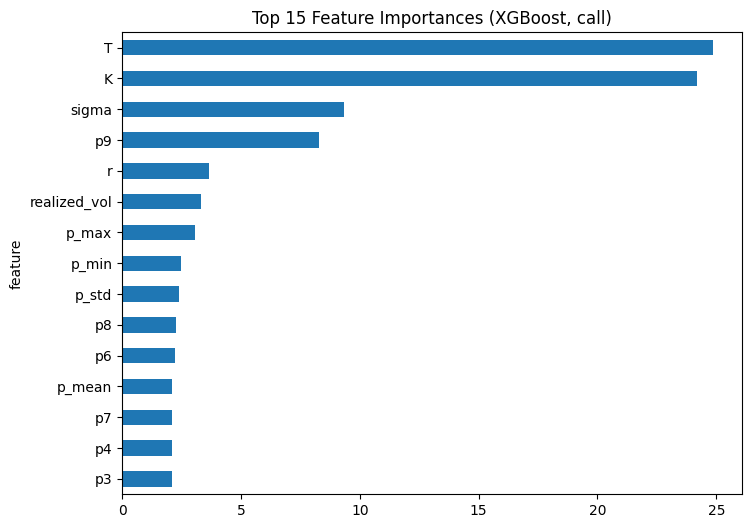


Training models for option type: digital

--- LightGBM ---

LightGBM Performance:
 RMSE = 0.3913
 MAE  = 0.3065
 R^2  = 0.2861

Top 15 features for LightGBM (digital):
     feature  importance
          p9    8.473016
realized_vol    7.720635
          p1    7.307937
          p3    7.304762
          p5    7.123810
          p2    7.041270
          p4    7.006349
          p8    6.882540
       p_std    6.638095
          p7    6.517460
          p6    6.320635
       p_min    5.126984
      p_mean    5.019048
       p_max    4.234921
           K    3.038095
Saved full feature importance to LightGBM_feature_importance_digital.csv


c:\Users\aisha\OneDrive\Desktop\GitHub\neural-pricer\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


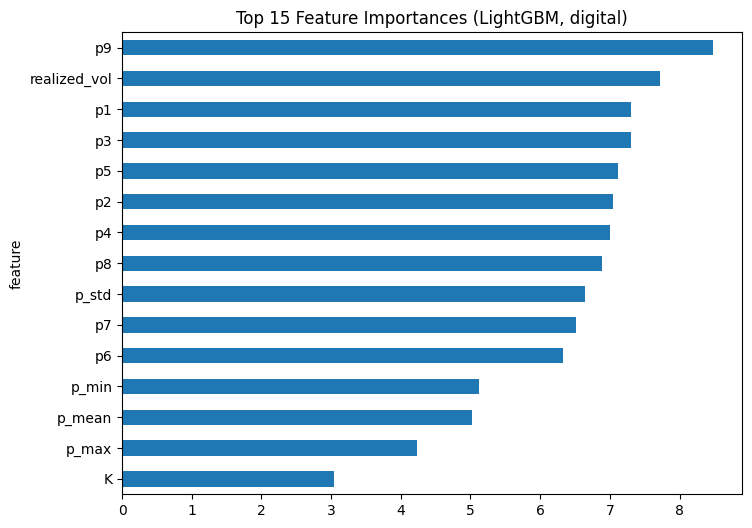


--- XGBoost ---

XGBoost Performance:
 RMSE = 0.3938
 MAE  = 0.3072
 R^2  = 0.2768

Top 15 features for XGBoost (digital):
     feature  importance
           K   18.953541
       sigma   17.356211
           r   13.139159
           T    9.916438
          p9    8.253417
       p_min    6.502356
      p_mean    2.455613
realized_vol    2.412570
          p8    2.368496
       p_max    2.355443
       p_std    2.316389
          p7    2.187494
          p6    2.130366
          p5    2.105934
          p4    2.075173
Saved full feature importance to XGBoost_feature_importance_digital.csv


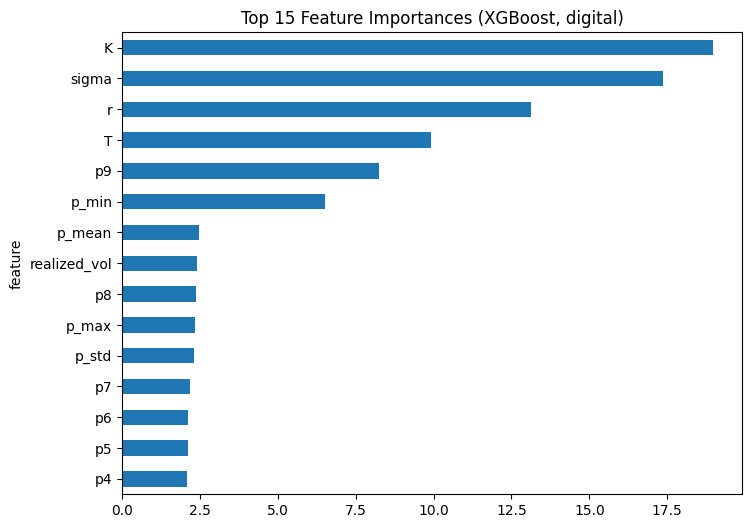


Training models for option type: asian

--- LightGBM ---

LightGBM Performance:
 RMSE = 11.5976
 MAE  = 6.1206
 R^2  = 0.6204

Top 15 features for LightGBM (asian):
     feature  importance
          p9    8.393651
realized_vol    7.822222
          p1    7.549206
          p2    7.457143
          p4    7.234921
          p3    7.187302
          p5    6.688889
          p8    6.450794
          p7    6.352381
          p6    6.304762
       p_std    5.342857
       p_max    5.126984
      p_mean    4.739683
       p_min    4.019048
           K    3.726984
Saved full feature importance to LightGBM_feature_importance_asian.csv


c:\Users\aisha\OneDrive\Desktop\GitHub\neural-pricer\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


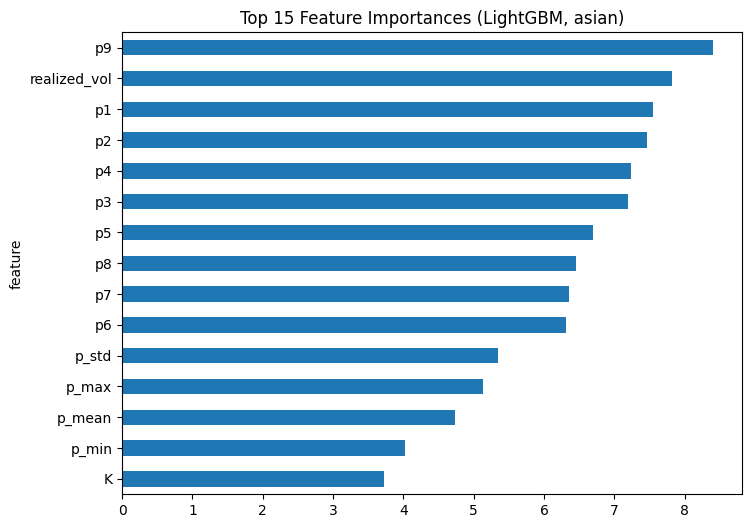


--- XGBoost ---

XGBoost Performance:
 RMSE = 11.7264
 MAE  = 6.1722
 R^2  = 0.6119

Top 15 features for XGBoost (asian):
     feature  importance
           T   33.225666
           K   29.415642
          p9   12.501311
           r    8.217761
       sigma    3.228678
       p_max    1.489013
          p8    1.233066
       p_min    1.125438
realized_vol    1.124634
      p_mean    1.100783
       p_std    1.079575
          p7    0.954634
          p5    0.944671
          p6    0.943819
          p4    0.936495
Saved full feature importance to XGBoost_feature_importance_asian.csv


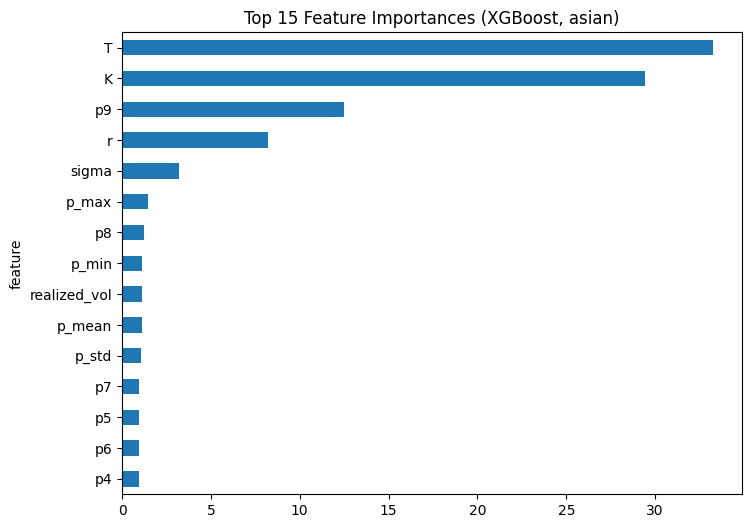

In [47]:
results = {}

for flag in option_flags:
    opt_label = option_map.get(flag, f"flag{int(flag)}")
    print("\n" + "="*50)
    print(f"Training models for option type: {opt_label}")
    print("="*50)
    
    # Filter dataset
    mask = X[:, -1] == flag
    X_sub, y_sub = X[mask], y[mask]
    
    # Drop option_flag column (not needed once split)
    X_sub = X_sub[:, :-1]
    sub_features = feature_names[:-1]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y_sub, test_size=0.2, random_state=42
    )
    
    try:
        print("\n--- LightGBM ---")
        lgb_model = lgb.LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            num_leaves=64,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        y_pred = lgb_model.predict(X_test)
        res = evaluate_model("LightGBM", y_test, y_pred)
        results[f"LGBM_{opt_label}"] = res
        show_feature_importance(lgb_model, sub_features, top_n=15,
                                model_name="LightGBM", suffix=opt_label)
    except Exception as e:
        print(f"LightGBM failed: {e}")

    try:
        print("\n--- XGBoost ---")
        xgb_model = xgb.XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            tree_method="hist",
            eval_metric="rmse"
        )
        xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = xgb_model.predict(X_test)
        res = evaluate_model("XGBoost", y_test, y_pred)
        results[f"XGB_{opt_label}"] = res
        show_feature_importance(xgb_model, sub_features, top_n=15,
                                model_name="XGBoost", suffix=opt_label)
    except Exception as e:
        print(f"XGBoost failed: {e}")

In [48]:
print("\n=== Summary of Results ===")
for k, v in results.items():
    print(f"{k}: {v}")


=== Summary of Results ===
LGBM_put: {'rmse': np.float64(16.841383694714633), 'mae': 11.301483370515895, 'r2': 0.5059173432230734}
XGB_put: {'rmse': np.float64(16.89424032888884), 'mae': 11.314036797930369, 'r2': 0.5028111224399695}
LGBM_call: {'rmse': np.float64(22.149654694189625), 'mae': 11.867540597726993, 'r2': 0.29477588386975706}
XGB_call: {'rmse': np.float64(22.25161198486157), 'mae': 11.952930347704964, 'r2': 0.28826849318641845}
LGBM_digital: {'rmse': np.float64(0.39127896020876407), 'mae': 0.3065263758495572, 'r2': 0.28608189218111324}
XGB_digital: {'rmse': np.float64(0.3938265727088914), 'mae': 0.30720165850311815, 'r2': 0.2767550030303053}
LGBM_asian: {'rmse': np.float64(11.597567901949654), 'mae': 6.120592460197425, 'r2': 0.6204190580017538}
XGB_asian: {'rmse': np.float64(11.72642164884908), 'mae': 6.172199800310432, 'r2': 0.6119376014555504}
